In [1]:
#==========================================================
# STEP 1: Install required libraries
#==========================================================
!pip install transformers datasets torch scikit-learn matplotlib

import pandas as pd
import numpy as np
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#==========================================================
# STEP 2: Load your dataset (Upload CSV to Colab first)
#==========================================================
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0], encoding='latin1')

#🔹 Replace column names here
TEXT_COL = "text"     # your text column name
LABEL_COL = "sentiment"   # label column name

df = df[[TEXT_COL, LABEL_COL]]
print(df.head())

KeyboardInterrupt: 

In [3]:
#==========================================================
# STEP 3: Preprocessing
#==========================================================
df.dropna(inplace=True)

# Map string labels to integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df[LABEL_COL] = df[LABEL_COL].map(label_mapping)
df[LABEL_COL] = df[LABEL_COL].astype(int)  # ensure numeric labels

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
#==========================================================
# STEP 4: Tokenization
#==========================================================
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

def tokenize(batch):
    return tokenizer(batch[TEXT_COL], padding=True, truncation=True, max_length=256)

train_encodings = tokenizer(list(train_df[TEXT_COL]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_df[TEXT_COL]), truncation=True, padding=True)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, list(train_df[LABEL_COL]))
test_dataset  = Dataset(test_encodings , list(test_df[LABEL_COL]))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [5]:
#==========================================================
# STEP 5: Model Setup
#==========================================================
num_labels = df[LABEL_COL].nunique()
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
#==========================================================
# STEP 6: Training Arguments
#==========================================================
EPOCHS = 5  # 🔹 Change epochs here manually or ask user input

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch", # Changed from evaluation_strategy
    save_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

In [7]:
#==========================================================
# STEP 7: Metrics Function
#==========================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [8]:
#==========================================================
# STEP 8: Train Model
#==========================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.617300,0.677824,0.735502,0.736873,0.735502,0.733862
2,0.395200,0.708441,0.743989,0.745582,0.743989,0.741796
3,0.181900,1.051134,0.755304,0.763028,0.755304,0.756484
4,0.290300,1.097686,0.768034,0.770917,0.768034,0.768793
5,0.016700,1.237005,0.753890,0.754640,0.753890,0.754099


{'eval_loss': 1.2370054721832275,
 'eval_accuracy': 0.7538896746817539,
 'eval_precision': 0.7546397777538615,
 'eval_recall': 0.7538896746817539,
 'eval_f1': 0.7540985668351148,
 'eval_runtime': 1.0741,
 'eval_samples_per_second': 658.246,
 'eval_steps_per_second': 82.863,
 'epoch': 5.0}


📊 TRAIN CONFUSION MATRIX


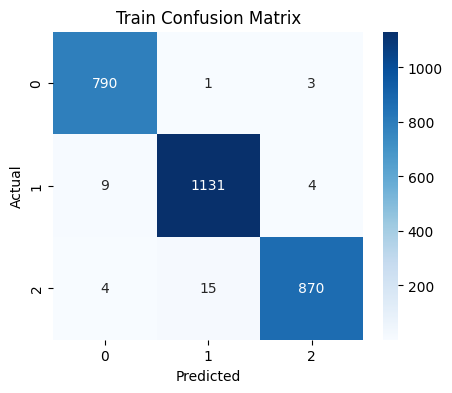


📊 TEST CONFUSION MATRIX


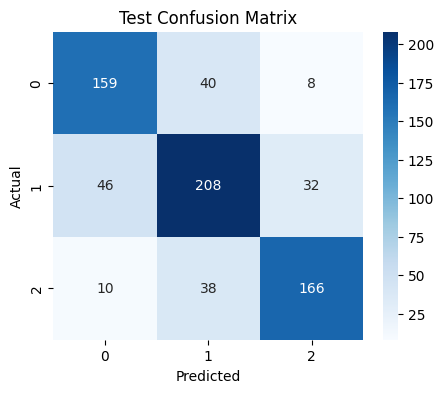

In [9]:
#==========================================================
# STEP 9: Confusion Matrix (Train + Test)
#==========================================================
def plot_confusion(dataset, title):
    preds = trainer.predict(dataset)
    cm = confusion_matrix(preds.label_ids, preds.predictions.argmax(-1))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

print("\n📊 TRAIN CONFUSION MATRIX")
plot_confusion(train_dataset,"Train Confusion Matrix")

print("\n📊 TEST CONFUSION MATRIX")
plot_confusion(test_dataset,"Test Confusion Matrix")

In [10]:
label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}

def predict_text(text):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    # Move tokens to the same device as the model
    tokens = {k: v.to(model.device) for k, v in tokens.items()}
    output = model(**tokens)
    pred = torch.argmax(output.logits).item()
    return label_map[pred]
predict_text("This laptop works very smoothly, I love it!")

'Positive'